# Isoform Analysis of RNASeq Data

### Pediatric AML, Pediatric Non-Leukemia, Adult AML
### Genes/Isoforms
* ADAR1 P110, P150 (ENST00000368474)
* MCL1-L (ENST00000369026)
* BCL2-L (ENST00000398117)
* PTPN6-003 (ENST00000416215)
* CD44 Isoforms
* CD47 Isoforms


In [1]:
library('IRdisplay')
library('limma')
library('edgeR')
library('Glimma')
library('ggplot2')
library('ggpubr')
library('Homo.sapiens')
library('statmod')
library('plyr')
library('dplyr')
library('gdata')
library('reshape2')
library('gplots')

EG2SYM <- toTable(org.Hs.egSYMBOL)
ENS2EG <- toTable(org.Hs.egENSEMBL2EG)
ENS2EG2SYM <- data.frame(gene_id=ENS2EG$gene_id, ens_id=ENS2EG, 
                         SYM=EG2SYM[match(ENS2EG$gene_id,EG2SYM$gene_id),"symbol"])

Warning message:
“package ‘IRdisplay’ was built under R version 4.1.0”
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, r

In [2]:
gSourceDir = "src/" # note trailing slash here but not below
for (i in dir(gSourceDir)) {
    source(paste0(gSourceDir, i))
}


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




### Preprocess RNASeq Gene Count Data and metadata

In [3]:
meta2 <- read.csv("../data/DeWerf_Jamieson_PediatricAMLmetadata_02282020.csv", stringsAsFactors=FALSE, header=TRUE)

meta2.Prog.filt <- meta2[meta2$Cell.type %in% "Prog",]
meta2.Prog.filt$Phenotype <- factor(as.character(meta2.Prog.filt$X), levels=c("PedAML", "AdultAML", "PedNL"))
meta2.Stem.filt <- meta2[meta2$Cell.type %in% "Stem",] 
meta2.Stem.filt$Phenotype <- factor(as.character(meta2.Stem.filt$X), levels=c("PedAML", "AdultAML", "PedNL"))

### Preprocess RNASeq Isoform Count Data and metadata

In [28]:
name <- "iso_comp"
name2 <- "20180417"
# Available on request due to size limitations
iso_rsem_new <- read.csv("../data/all_isoforms_results.txt", sep="\t", stringsAsFactors=FALSE) 
iso_counts_new <- iso_rsem_new[,sapply(colnames(iso_rsem_new), function(x) any(grepl(".results_expected_count",x)))]
colnames(iso_counts_new) <- gsub(".isoforms.results_expected_count","", colnames(iso_counts_new))
colnames(iso_counts_new) <- gsub("X09x00020pxPLUSPLUS", "X09x00020xPLUSPLUS", gsub("^cell", "Xcell", 
                                  gsub("_S[0-9]_R1_001","", colnames(iso_counts_new))))
row.names(iso_counts_new) <- iso_rsem_new$transcript_id
iso_gene_table <- iso_rsem_new[,1:2]

In [5]:
isos <- AnnotationDbi::select(Homo.sapiens, keys=gsub("[.].*$","", iso_gene_table$gene_id), columns=c("SYMBOL", "ENSEMBL", "ENTREZID"), 
                keytype="ENSEMBL")
iso_gene_table_anno <- cbind(iso_gene_table, isos[match(gsub("[.].*$","", iso_gene_table$gene_id), isos$ENSEMBL),2:3])


'select()' returned many:many mapping between keys and columns



In [6]:
load("../data/gencodev19_ANNOT.RData") 
ANNOT_out <- merge(ANNOT, iso_counts_new, by.x="transcript_id", by.y="row.names", all.y=TRUE)
ANNOT_protein_coding <- subset(ANNOT, gene_type == "protein_coding")
ANNOT_ncRNA <- subset(ANNOT, gene_type %in% c("lincRNA", "antisense", "processed_transcript","sense_overlapping", "sense_intronic") )
#make list of IDs to query
protein_coding_ids <- ANNOT_protein_coding$gene_id
ncRNA_ids <- ANNOT_ncRNA$gene_id

iso_gene_table_anno_pc <- iso_gene_table_anno[gsub("[.].*$","", iso_gene_table_anno$gene_id) %in%
                                             gsub("[.].*$","", protein_coding_ids),]
iso_counts_new_pc <- iso_counts_new[rownames(iso_counts_new) %in% iso_gene_table_anno_pc$transcript_id,]
rownames(iso_counts_new_pc) <- gsub("[.].*$","", rownames(iso_counts_new_pc))


In [7]:
PedAML.Prog.meta <- meta2[which(meta2$X %in% c("PedAML") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Prog")),]
AdultAML.Prog.meta <- meta2[which(meta2$X %in% c("AdultAML") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Prog")),]
PedNL.Prog.meta <- meta2[which(meta2$X %in% c("PedNL") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Prog")),]

PedAML.Prog.samps <- match(paste0("X", PedAML.Prog.meta$Sample), colnames(iso_counts_new_pc))
AdultAML.Prog.samps <- match(paste0("X",AdultAML.Prog.meta$Sample), colnames(iso_counts_new_pc))
PedNL.Prog.samps <- match(paste0("X",PedNL.Prog.meta$Sample), colnames(iso_counts_new_pc))

PedAML.Prog.meta.filt <- meta2.Prog.filt[which(meta2.Prog.filt$X %in% c("PedAML")),]
AdultAML.Prog.meta.filt <- meta2.Prog.filt[which(meta2.Prog.filt$X %in% c("AdultAML")),]
PedNL.Prog.meta.filt <- meta2.Prog.filt[which(meta2.Prog.filt$X %in% c("PedNL")),]

PedAML.Prog.samps.f <- match(paste0("X", PedAML.Prog.meta.filt$Sample), colnames(iso_counts_new_pc))
AdultAML.Prog.samps.f <- match(paste0("X", AdultAML.Prog.meta.filt$Sample), colnames(iso_counts_new_pc))
PedNL.Prog.samps.f <- match(paste0("X", PedNL.Prog.meta.filt$Sample), colnames(iso_counts_new_pc))

In [8]:
PedAML.Stem.meta <- meta2[which(meta2$X %in% c("PedAML") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Stem")),]
AdultAML.Stem.meta <- meta2[which(meta2$X %in% c("AdultAML") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Stem")),]
PedNL.Stem.meta <- meta2[which(meta2$X %in% c("PedNL") &
             meta2$Tissue.Source %in% c("BM", "PB") & 
             meta2$Cell.type %in% c("Stem")),]

PedAML.Stem.samps <- match(paste0("X", PedAML.Stem.meta$Sample), colnames(iso_counts_new_pc))
AdultAML.Stem.samps <- match(paste0("X", AdultAML.Stem.meta$Sample), colnames(iso_counts_new_pc))
PedNL.Stem.samps <- match(paste0("X", PedNL.Stem.meta$Sample), colnames(iso_counts_new_pc))

PedAML.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$X %in% c("PedAML")),]
AdultAML.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$X %in% c("AdultAML")),]
PedNL.Stem.meta.filt <- meta2.Stem.filt[which(meta2.Stem.filt$X %in% c("PedNL")),]

PedAML.Stem.samps.f <- match(paste0("X", PedAML.Stem.meta.filt$Sample), colnames(iso_counts_new_pc))
AdultAML.Stem.samps.f <- match(paste0("X", AdultAML.Stem.meta.filt$Sample), colnames(iso_counts_new_pc))
PedNL.Stem.samps.f <- match(paste0("X", PedNL.Stem.meta.filt$Sample), colnames(iso_counts_new_pc))


### Prepare DGELists

In [10]:
iso_counts_filt.Prog.filt <- iso_counts_new_pc[,c(PedAML.Prog.samps.f, AdultAML.Prog.samps.f, PedNL.Prog.samps.f)]
iso_counts_filt.Stem.filt <- iso_counts_new_pc[,c(PedAML.Stem.samps.f, AdultAML.Stem.samps.f, PedNL.Stem.samps.f)]

meta.Prog.filt <- rbind(PedAML.Prog.meta.filt, AdultAML.Prog.meta.filt, PedNL.Prog.meta.filt)
meta.Stem.filt <- rbind(PedAML.Stem.meta.filt, AdultAML.Stem.meta.filt, PedNL.Stem.meta.filt)

id_list.Prog.filt <- gsub("[.].*$","", rownames(iso_counts_filt.Prog.filt))
id_list.Stem.filt <- gsub("[.].*$","", rownames(iso_counts_filt.Stem.filt))
rownames(iso_counts_filt.Prog.filt) <- id_list.Prog.filt
rownames(iso_counts_filt.Stem.filt) <- id_list.Stem.filt

DGE_all.Prog.filt <- DGEList(counts = iso_counts_filt.Prog.filt, lib.size = colSums(iso_counts_filt.Prog.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Prog.filt)), samples = meta.Prog.filt,
                      group = meta.Prog.filt$Phenotype, genes = id_list.Prog.filt, remove.zeros = FALSE) 
DGE_all.Prog.filt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id),
                                          id_list.Prog.filt),c("ENTREZID","SYMBOL")]

DGE_all.Stem.filt <- DGEList(counts = iso_counts_filt.Stem.filt, lib.size = colSums(iso_counts_filt.Stem.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Stem.filt)), samples = meta.Stem.filt,
                      group = meta.Stem.filt$Phenotype, genes = id_list.Stem.filt, remove.zeros = FALSE) 
DGE_all.Stem.filt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id)
                                                         ,id_list.Stem.filt),c("ENTREZID","SYMBOL")]
cpm.Prog.filt <- cpm(DGE_all.Prog.filt)
lcpm.Prog.filt <- cpm(DGE_all.Prog.filt, log=TRUE)
DGE_all.Prog.unfilt <- calcNormFactors(DGE_all.Prog.filt, method="TMM")
lcpm.Prog.unfilt <- cpm(DGE_all.Prog.unfilt, log=TRUE)
keep.exprs.Prog.filt <- rowSums(cpm.Prog.filt>1)>=10
DGE_all.Prog.filt <- DGE_all.Prog.filt[keep.exprs.Prog.filt,, keep.lib.sizes=FALSE]
DGE_all.Prog.filt <- calcNormFactors(DGE_all.Prog.filt, method = "TMM")

lcpm2.Prog.filt <- cpm(DGE_all.Prog.filt, log=TRUE)

cpm.Stem.filt <- cpm(DGE_all.Stem.filt)
lcpm.Stem.filt <- cpm(DGE_all.Stem.filt, log=TRUE)
DGE_all.Stem.unfilt <- calcNormFactors(DGE_all.Stem.filt, method="TMM")
lcpm.Stem.unfilt <- cpm(DGE_all.Stem.unfilt, log=TRUE)
keep.exprs.Stem.filt <- rowSums(cpm.Stem.filt>1)>=7
DGE_all.Stem.filt <- DGE_all.Stem.filt[keep.exprs.Stem.filt,, keep.lib.sizes=FALSE]
DGE_all.Stem.filt <- calcNormFactors(DGE_all.Stem.filt, method = "TMM")

lcpm2.Stem.filt <- cpm(DGE_all.Stem.filt, log=TRUE)

In [11]:
DGE_all.Prog.unfilt <- DGEList(counts = iso_counts_filt.Prog.filt, lib.size = colSums(iso_counts_filt.Prog.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Prog.filt)), samples = meta.Prog.filt,
                      group = meta.Prog.filt$Phenotype, genes = id_list.Prog.filt, remove.zeros = FALSE) 
DGE_all.Prog.unfilt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id),
                                          id_list.Prog.filt),c("ENTREZID","SYMBOL")]

DGE_all.Stem.unfilt <- DGEList(counts = iso_counts_filt.Stem.filt, lib.size = colSums(iso_counts_filt.Stem.filt),
                      norm.factors = rep(1,ncol(iso_counts_filt.Stem.filt)), samples = meta.Stem.filt,
                      group = meta.Stem.filt$Phenotype, genes = id_list.Stem.filt, remove.zeros = FALSE) 
DGE_all.Stem.unfilt$genes[,2:3] <- iso_gene_table_anno_pc[match(gsub("[.].*$","", iso_gene_table_anno_pc$transcript_id)
                                                         ,id_list.Stem.filt),c("ENTREZID","SYMBOL")]

DGE_all.Prog.unfilt <- calcNormFactors(DGE_all.Prog.unfilt, method = "TMM")

lcpm2.Prog.unfilt <- cpm(DGE_all.Prog.unfilt, log=TRUE)

DGE_all.Stem.unfilt <- calcNormFactors(DGE_all.Stem.unfilt, method = "TMM")

lcpm2.Stem.unfilt <- cpm(DGE_all.Stem.unfilt, log=TRUE)

## Make Boxplots

## Fig 4e, S3h - Boxplot of CD44 Isoform Expression

In [25]:
CD44.tx <- read.table(file="../data/CD44_tx.txt", sep="\t", header=FALSE, stringsAsFactors=FALSE)
colnames(CD44.tx) <- c("IsoName", "ENS")
CD44.tx <- with(CD44.tx, CD44.tx[order(IsoName),])
CD44.tx$IsoName <- factor(as.character(CD44.tx$IsoName), 
                           levels=as.character(CD44.tx$IsoName))

CD44.tx_exp <- CD44.tx[CD44.tx$ENS %in% c(rownames(lcpm2.Prog.filt), rownames(lcpm2.Stem.filt)),]

CD44.tx.lcpm.Prog.df <- as.data.frame(t(lcpm2.Prog.unfilt[match(CD44.tx_exp$ENS, rownames(lcpm2.Prog.unfilt)),]))
CD44.tx.lcpm.Stem.df <- as.data.frame(t(lcpm2.Stem.unfilt[match(CD44.tx_exp$ENS, rownames(lcpm2.Stem.unfilt)),]))

for (i in 1:ncol(CD44.tx.lcpm.Prog.df)) {
    CD44.tx.lcpm.Prog.df[which(CD44.tx.lcpm.Prog.df[,i] < 0),i] <- 0 
    CD44.tx.lcpm.Stem.df[which(CD44.tx.lcpm.Stem.df[,i] < 0),i] <- 0     
}
CD44.tx.lcpm.Prog.df$Phenotype <- factor(as.character(meta.Prog.filt[match(rownames(CD44.tx.lcpm.Prog.df), 
                                                                paste0("X", meta.Prog.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))

CD44.tx.lcpm.Stem.df$Phenotype <- factor(as.character(meta.Stem.filt[match(rownames(CD44.tx.lcpm.Stem.df), 
                                                                paste0("X", meta.Stem.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))
colnames(CD44.tx.lcpm.Stem.df)[1:nrow(CD44.tx_exp)] <- colnames(CD44.tx.lcpm.Prog.df)[1:nrow(CD44.tx_exp)] <- as.character(CD44.tx_exp$IsoName)

CD44.tx.lcpm.Prog.df.m <- melt(variable.name = "Isoform", CD44.tx.lcpm.Prog.df)
CD44.tx.lcpm.Stem.df.m <- melt(variable.name = "Isoform", CD44.tx.lcpm.Stem.df)
CD44.tx.lcpm.Prog.df.m <- subset(CD44.tx.lcpm.Prog.df.m, Phenotype != "AdultAML")
CD44.tx.lcpm.Stem.df.m <- subset(CD44.tx.lcpm.Stem.df.m, Phenotype != "AdultAML")

Using Phenotype as id variables

Using Phenotype as id variables



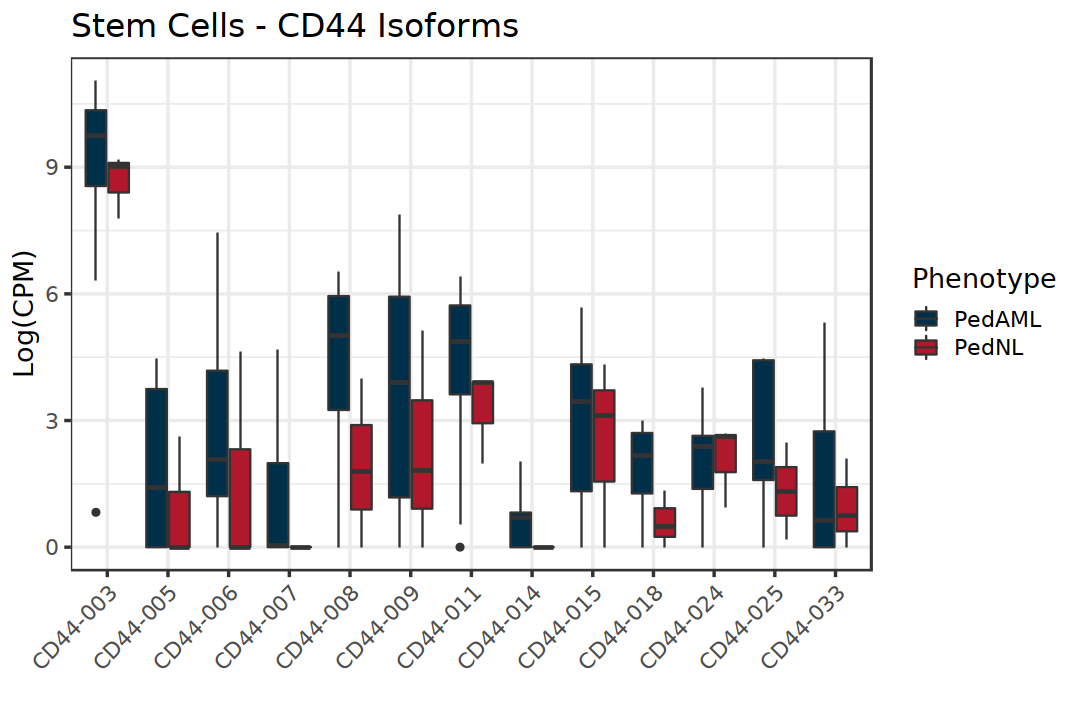

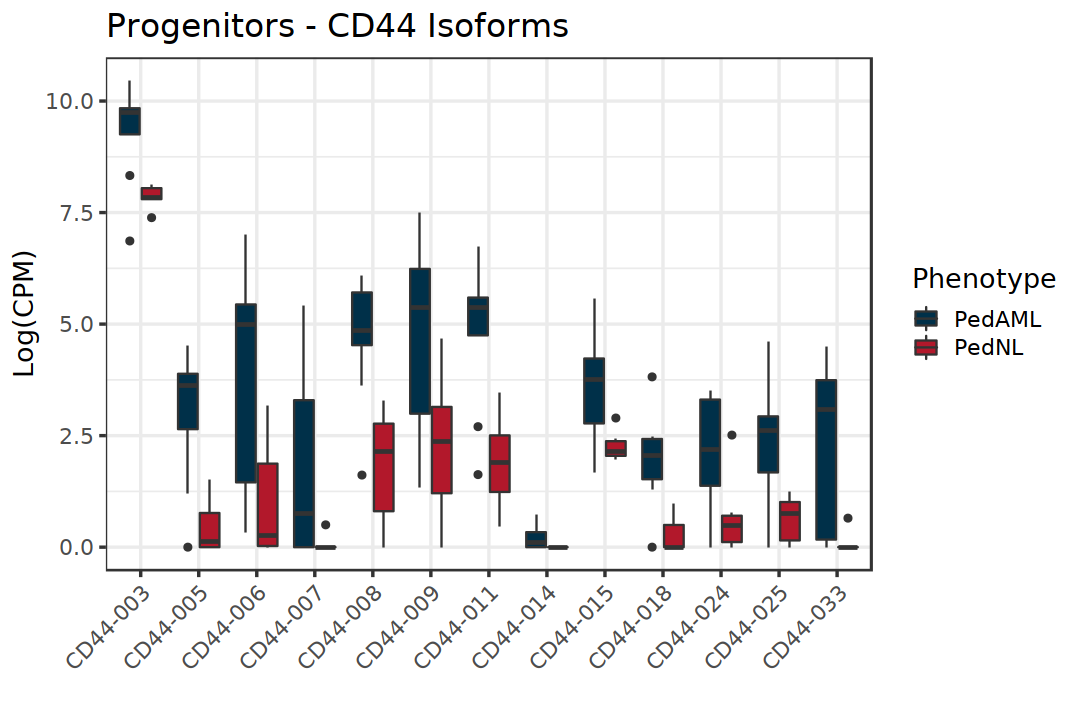

In [26]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(CD44.tx.lcpm.Stem.df.m, aes(x=Isoform, y=value, fill=Phenotype)) + xlab("") +
    geom_boxplot(aes(fill=Phenotype)) + #geom_point(shape=19, position=position_jitterdodge()) +
    scale_fill_manual(values = c("#003049", "#B2182B")) +
    theme_bw(base_size=16) + ylab("Log(CPM)") + labs(title="Stem Cells - CD44 Isoforms") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) 

options(repr.plot.width=9, repr.plot.height=6)
ggplot(CD44.tx.lcpm.Prog.df.m, aes(x=Isoform, y=value, fill=Phenotype)) + xlab("") +
    geom_boxplot(aes(fill=Phenotype)) + #geom_point(shape=19, position=position_jitterdodge()) +
    scale_fill_manual(values = c("#003049", "#B2182B")) +
    theme_bw(base_size=16) + ylab("Log(CPM)") + labs(title="Progenitors - CD44 Isoforms") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) 


## Fig 4f, S3i - Boxplot of CD47 Isoform Expression

In [14]:
CD47.tx <- read.table(file="../data/CD47_tx.txt", sep="\t", header=FALSE, stringsAsFactors=FALSE)
colnames(CD47.tx) <- c("IsoName", "ENS")
CD47.tx <- with(CD47.tx, CD47.tx[order(IsoName),])
CD47.tx$IsoName <- factor(as.character(CD47.tx$IsoName), 
                           levels=as.character(CD47.tx$IsoName))
CD47.tx <- CD47.tx[-c(3,6),]

CD47.tx.lcpm.Prog.unfilt <- lcpm2.Prog.unfilt[match(CD47.tx$ENS, rownames(lcpm2.Prog.unfilt)),]
CD47.tx.lcpm.Stem.unfilt <- lcpm2.Stem.unfilt[match(CD47.tx$ENS, rownames(lcpm2.Stem.unfilt)),]

CD47.tx.lcpm.Prog.df <- as.data.frame(t(CD47.tx.lcpm.Prog.unfilt))
CD47.tx.lcpm.Stem.df <- as.data.frame(t(CD47.tx.lcpm.Stem.unfilt))
for (i in 1:ncol(CD47.tx.lcpm.Prog.df)) {
    CD47.tx.lcpm.Prog.df[which(CD47.tx.lcpm.Prog.df[,i] < 0),i] <- 0 
    CD47.tx.lcpm.Stem.df[which(CD47.tx.lcpm.Stem.df[,i] < 0),i] <- 0     
}
CD47.tx.lcpm.Prog.df$Phenotype <- factor(as.character(meta.Prog.filt[match(rownames(CD47.tx.lcpm.Prog.df), 
                                                                paste0("X", meta.Prog.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))

CD47.tx.lcpm.Stem.df$Phenotype <- factor(as.character(meta.Stem.filt[match(rownames(CD47.tx.lcpm.Stem.df), 
                                                                paste0("X", meta.Stem.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))
colnames(CD47.tx.lcpm.Stem.df)[1:nrow(CD47.tx)] <- colnames(CD47.tx.lcpm.Prog.df)[1:nrow(CD47.tx)] <- as.character(CD47.tx$IsoName)


Using Phenotype as id variables

Using Phenotype as id variables



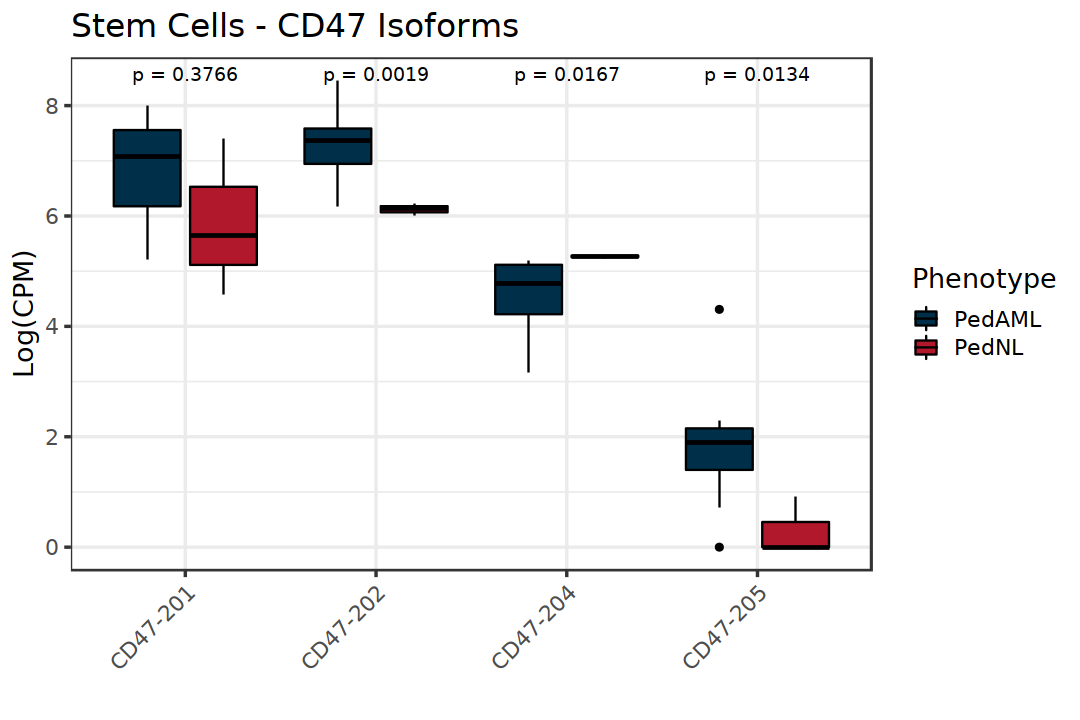

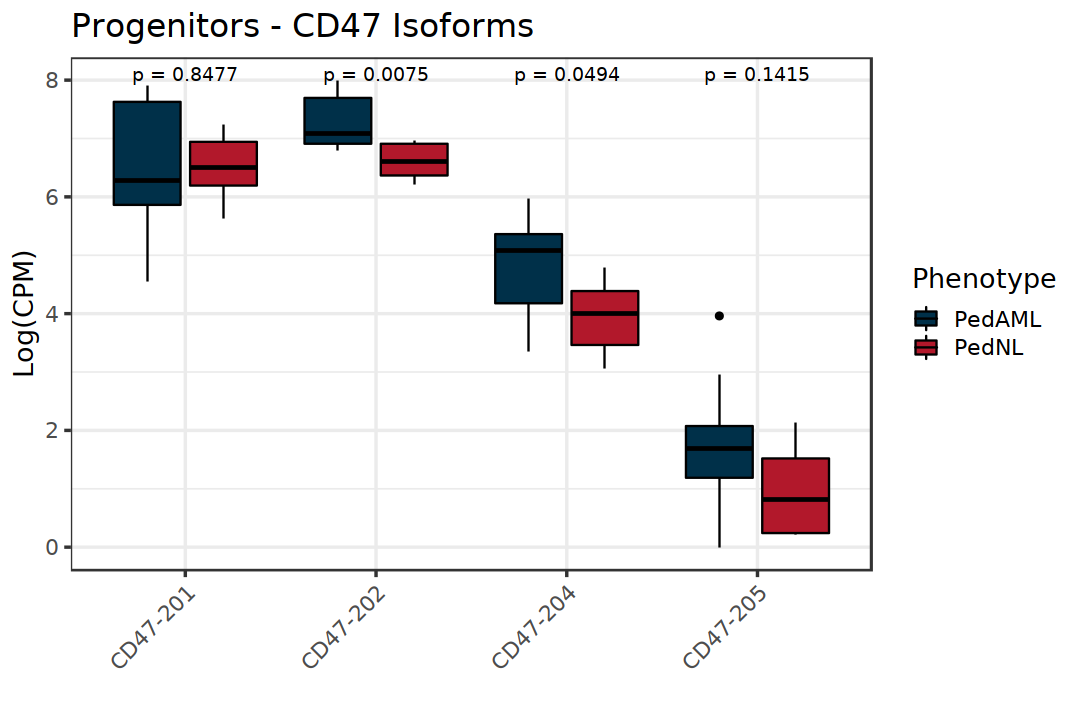

In [27]:
CD47.tx.lcpm.Prog.df.m <- melt(variable.name = "Isoform", CD47.tx.lcpm.Prog.df)
CD47.tx.lcpm.Stem.df.m <- melt(variable.name = "Isoform", CD47.tx.lcpm.Stem.df)
CD47.tx.lcpm.Prog.df.m <- subset(CD47.tx.lcpm.Prog.df.m, Phenotype != "AdultAML")
CD47.tx.lcpm.Stem.df.m <- subset(CD47.tx.lcpm.Stem.df.m, Phenotype != "AdultAML")
CD47.tx.lcpm.Prog.df.m <- CD47.tx.lcpm.Prog.df.m[!CD47.tx.lcpm.Prog.df.m$Isoform %in% c("CD47-203", "CD47-206"),]
CD47.tx.lcpm.Stem.df.m <- CD47.tx.lcpm.Stem.df.m[!CD47.tx.lcpm.Stem.df.m$Isoform %in% c("CD47-203", "CD47-206"),]

ggboxplot(CD47.tx.lcpm.Stem.df.m, x="Isoform", y="value", fill="Phenotype", #add=c("jitter"),
         palette = c("#003049", "#B2182B")) + xlab("") +
    theme_bw(base_size=16) + ylab("Log(CPM)") + labs(title="Stem Cells - CD47 Isoforms") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
    stat_compare_means(aes(group=Phenotype), method="t.test", label = "p.format")

ggboxplot(CD47.tx.lcpm.Prog.df.m, x="Isoform", y="value", fill="Phenotype", #add=c("jitter"),
          palette = c("#003049", "#B2182B")) + xlab("") +
    theme_bw(base_size=16) + ylab("Log(CPM)") + labs(title="Progenitors - CD47 Isoforms") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
    stat_compare_means(aes(group=Phenotype), method="t.test", label = "p.format")


## Fig S4b - Boxplot of MCL1-L 

In [16]:
X.tx <- c("ENST00000369026", "ENST00000307940", "ENST00000398117", "ENST00000307677", "ENST00000528086", "ENST00000420218", 
         "ENST00000302516", "ENST00000566095", "ENST00000577085")

X.tx.exp.Prog.filt <- DGE_all.Prog.filt$counts[rownames(DGE_all.Prog.filt$counts) %in% X.tx,]
X.tx.exp.Stem.filt <- DGE_all.Stem.filt$counts[rownames(DGE_all.Stem.filt$counts) %in% X.tx,]
X.tx.lcpm.Prog.filt <- lcpm2.Prog.filt[rownames(lcpm2.Prog.filt) %in% X.tx,]
X.tx.lcpm.Stem.filt <- lcpm2.Stem.filt[rownames(lcpm2.Stem.filt) %in% X.tx,]

X.tx.lcpm.Prog.df <- as.data.frame(t(X.tx.lcpm.Prog.filt))
X.tx.lcpm.Prog.df$Phenotype <- factor(as.character(meta.Prog.filt[match(rownames(X.tx.lcpm.Prog.df), 
                                                                paste0("X", meta.Prog.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))

X.tx.lcpm.Stem.df <- as.data.frame(t(X.tx.lcpm.Stem.filt))
X.tx.lcpm.Stem.df$Phenotype <- factor(as.character(meta.Stem.filt[match(rownames(X.tx.lcpm.Stem.df), 
                                                                paste0("X", meta.Stem.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))
colnames(X.tx.lcpm.Stem.df)[1:6] <- colnames(X.tx.lcpm.Prog.df)[1:6] <- c("PTK2B.202", "MCL1.S", "MCL1.L", "BCLX.L", 
                                                                          "BCL2.L", "SF3B3.201")

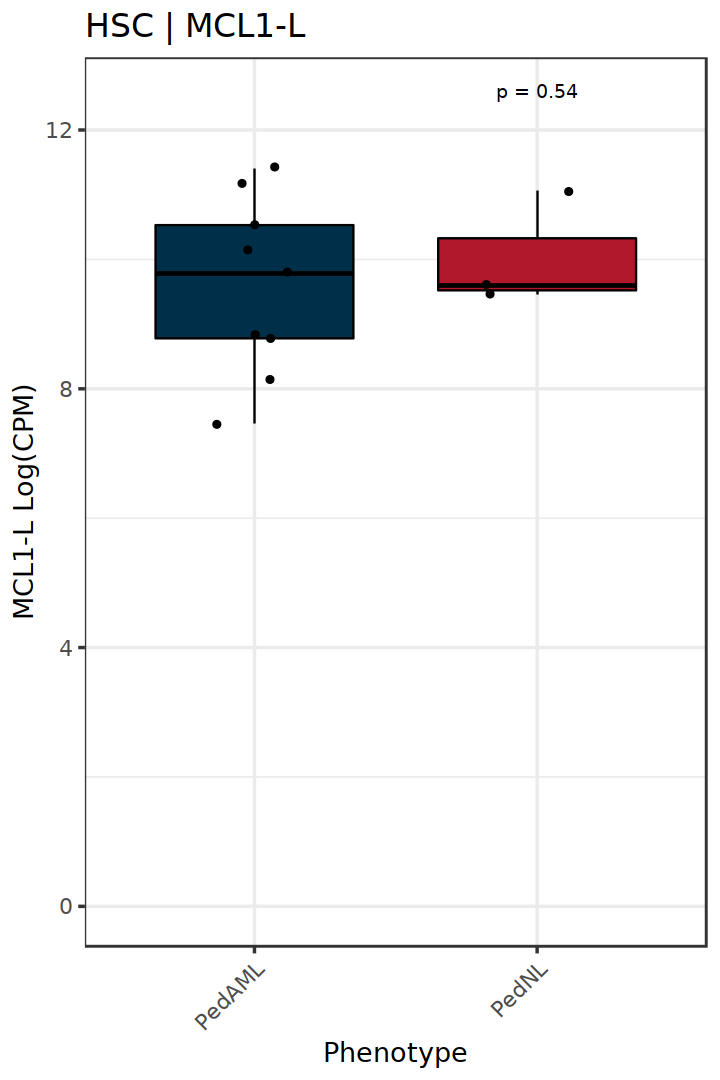

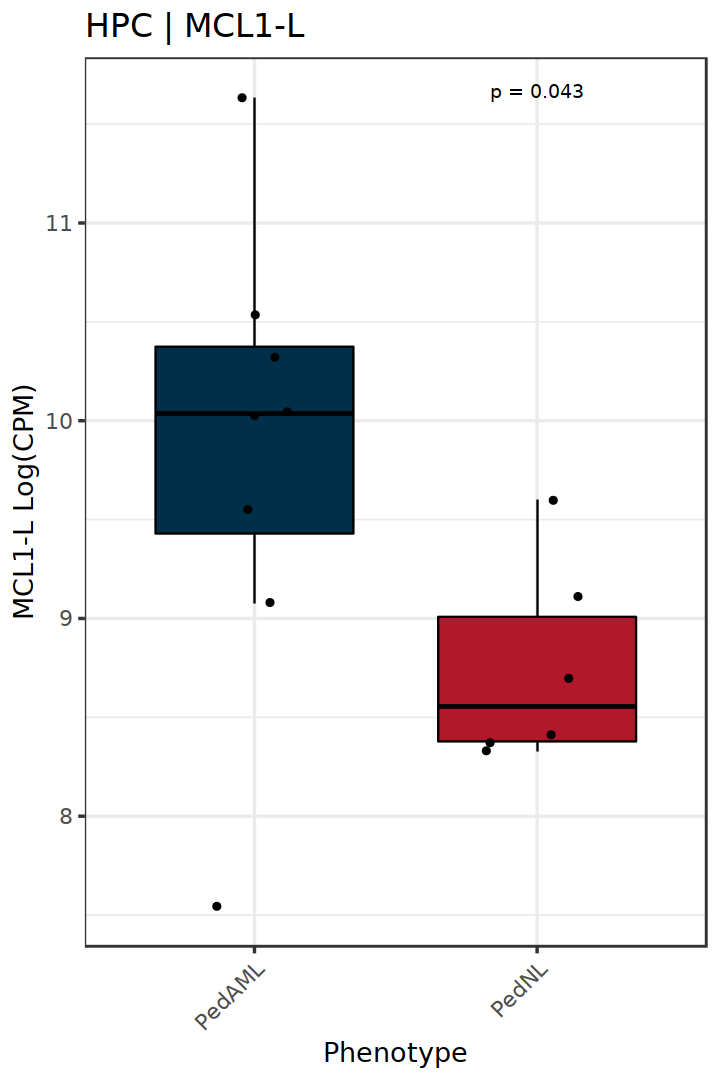

In [17]:
options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(X.tx.lcpm.Stem.df, Phenotype != "AdultAML"), x="Phenotype", y="MCL1.L", add="jitter", fill="Phenotype",
         palette = c("#003049","#B2182B")) + ylim(0,12.5) +
    theme_bw(base_size=16) + ylab("MCL1-L Log(CPM)") + labs(title="HSC | MCL1-L") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    theme(legend.position="none") + 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")

options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(X.tx.lcpm.Prog.df[-7,], Phenotype != "AdultAML"), x="Phenotype", y="MCL1.L", add="jitter", fill="Phenotype",
         palette = c("#003049","#B2182B")) +  
    theme_bw(base_size=16) + ylab("MCL1-L Log(CPM)") + labs(title="HPC | MCL1-L") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
    theme(legend.position="none") + 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")


## Fig S4c - Boxplot of BCL2-L

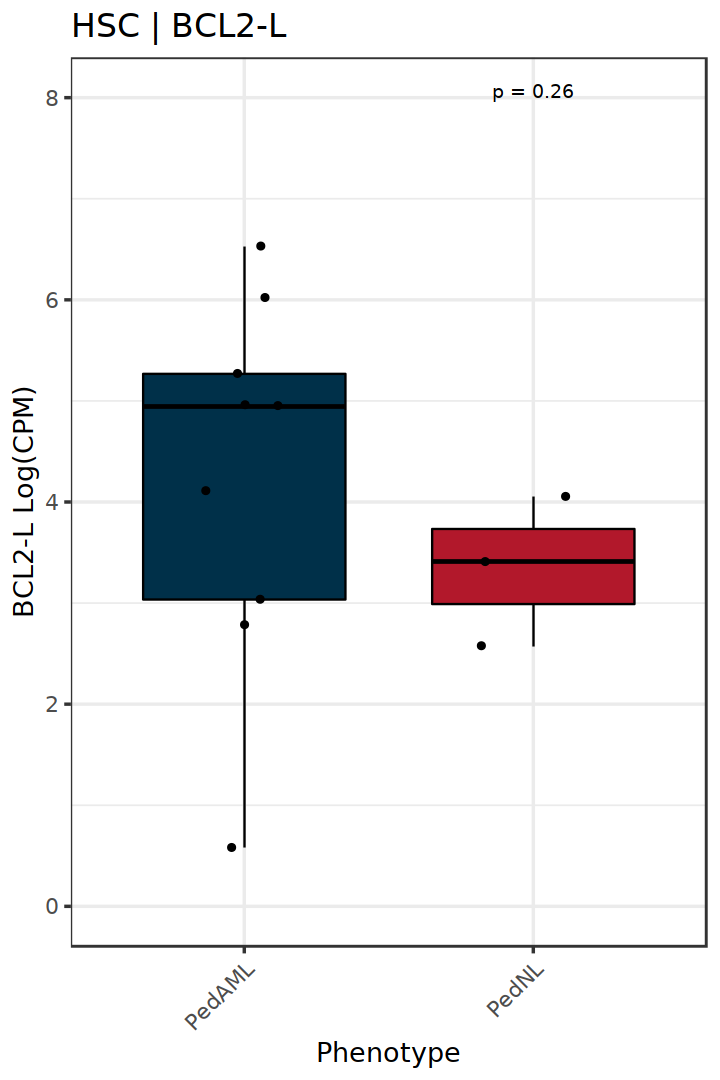

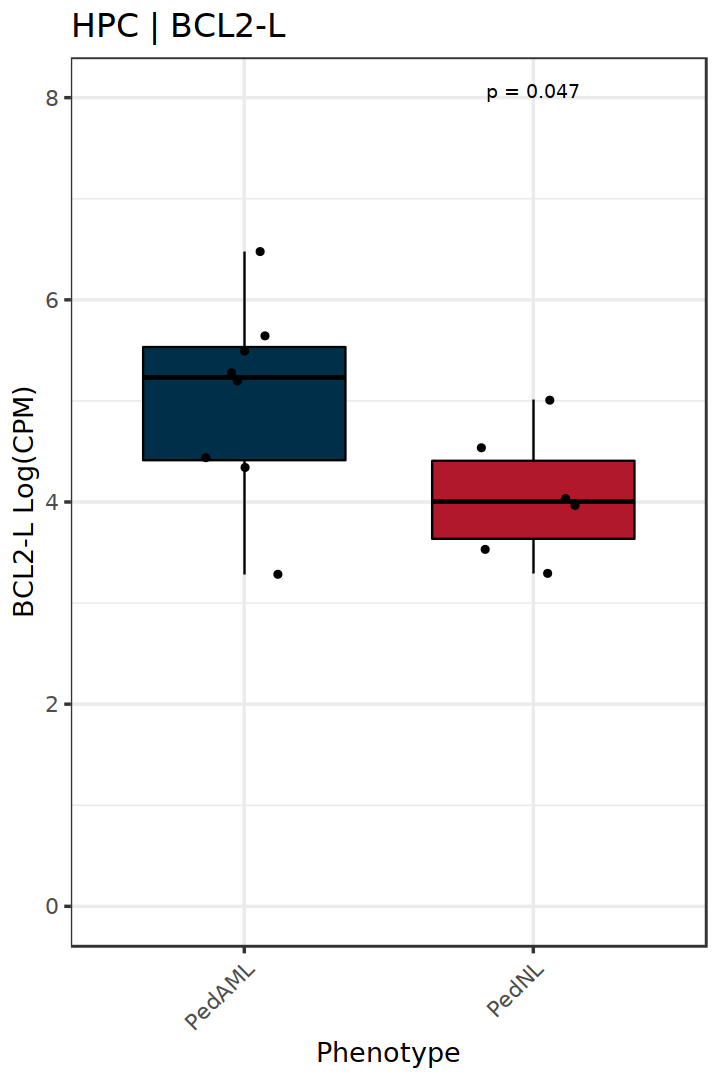

In [18]:
options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(X.tx.lcpm.Stem.df, Phenotype != "AdultAML"), x="Phenotype", y="BCL2.L", add=c("jitter"), fill="Phenotype",
         palette = c("#003049", "#B2182B")) + ylim(0,8) +
    theme_bw(base_size=16) + ylab("BCL2-L Log(CPM)") + labs(title="HSC | BCL2-L") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none")+ 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")

options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(X.tx.lcpm.Prog.df[-5,], Phenotype != "AdultAML"), x="Phenotype", y="BCL2.L", add=c("jitter"), fill="Phenotype",
         palette = c("#003049", "#B2182B")) + ylim(0,8) +
    theme_bw(base_size=16) + ylab("BCL2-L Log(CPM)") + labs(title="HPC | BCL2-L") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none")+ 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")


In [19]:
ADAR.tx <- c("ENST00000368471", "ENST00000368474")
ADAR.tx.exp.Prog.filt <- DGE_all.Prog.filt$counts[rownames(DGE_all.Prog.filt$counts) %in% ADAR.tx,]
ADAR.tx.exp.Stem.filt <- DGE_all.Stem.filt$counts[rownames(DGE_all.Stem.filt$counts) %in% ADAR.tx,]

ADAR.tx.lcpm.Prog.filt <- lcpm2.Prog.filt[rownames(lcpm2.Prog.filt) %in% ADAR.tx,]
ADAR.tx.lcpm.Stem.filt <- lcpm2.Stem.filt[rownames(lcpm2.Stem.filt) %in% ADAR.tx,]
ADAR.tx.lcpm.exp <- list(Prog=ADAR.tx.lcpm.Prog.filt, Stem=ADAR.tx.lcpm.Stem.filt)
ADAR.tx.lcpm <- do.call(cbind, ADAR.tx.lcpm.exp)
ADAR.tx.ratios <- apply(ADAR.tx.lcpm, 2, function(x) x[2] - x[1])
names(ADAR.tx.ratios) <- gsub("_S[0-9]+$", "", names(ADAR.tx.ratios))
    
ADAR.tx.lcpm.Prog.ratios <- apply(ADAR.tx.lcpm.Prog.filt, 2, function(x) x[2] - x[1])
names(ADAR.tx.lcpm.Prog.ratios) <- gsub("_S[0-9]+$", "", names(ADAR.tx.lcpm.Prog.ratios))
ADAR.tx.lcpm.Prog.ratios.df <- data.frame(Sample=names(ADAR.tx.lcpm.Prog.ratios), 
                                          value=ADAR.tx.lcpm.Prog.ratios,
                                          Phenotype=factor(as.character(meta.Prog.filt[match(names(ADAR.tx.lcpm.Prog.ratios), 
                                                                paste0("X",meta.Prog.filt$Sample)),"X"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL")))

ADAR.tx.lcpm.Stem.ratios <- apply(ADAR.tx.lcpm.Stem.filt, 2, function(x) x[2] - x[1])
names(ADAR.tx.lcpm.Stem.ratios) <- gsub("_S[0-9]+$", "", names(ADAR.tx.lcpm.Stem.ratios))
ADAR.tx.lcpm.Stem.ratios.df <- data.frame(Sample=names(ADAR.tx.lcpm.Stem.ratios), 
                                          value=ADAR.tx.lcpm.Stem.ratios,
                                          Phenotype=factor(as.character(meta.Stem.filt[match(names(ADAR.tx.lcpm.Stem.ratios), 
                                                                paste0("X",meta.Stem.filt$Sample)),"X"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL")))


In [20]:
ADAR.tx.lcpm.Prog.ratios.df$ADARp110.expr <- ADAR.tx.lcpm[1, match(ADAR.tx.lcpm.Prog.ratios.df$Sample, 
                                                              colnames(ADAR.tx.lcpm))]
ADAR.tx.lcpm.Prog.ratios.df$ADARp150.expr <- ADAR.tx.lcpm[2, match(ADAR.tx.lcpm.Prog.ratios.df$Sample, 
                                                              colnames(ADAR.tx.lcpm))]
ADAR.tx.lcpm.Stem.ratios.df$ADARp110.expr <- ADAR.tx.lcpm[1, match( ADAR.tx.lcpm.Stem.ratios.df$Sample, 
                                                              colnames(ADAR.tx.lcpm))]
ADAR.tx.lcpm.Stem.ratios.df$ADARp150.expr <- ADAR.tx.lcpm[2, match(ADAR.tx.lcpm.Stem.ratios.df$Sample,
                                                               colnames(ADAR.tx.lcpm))]
ADAR.tx.lcpm.all.ratios.df <- cbind.data.frame(rbind.data.frame(ADAR.tx.lcpm.Prog.ratios.df, 
                                                              ADAR.tx.lcpm.Stem.ratios.df), 
                                             Cell.type=c(rep("Prog", nrow(ADAR.tx.lcpm.Prog.ratios.df)),
                                                         rep("Stem", nrow(ADAR.tx.lcpm.Stem.ratios.df))))


## Fig S4d - Boxplot of ADAR1 P150/P110 Ratio

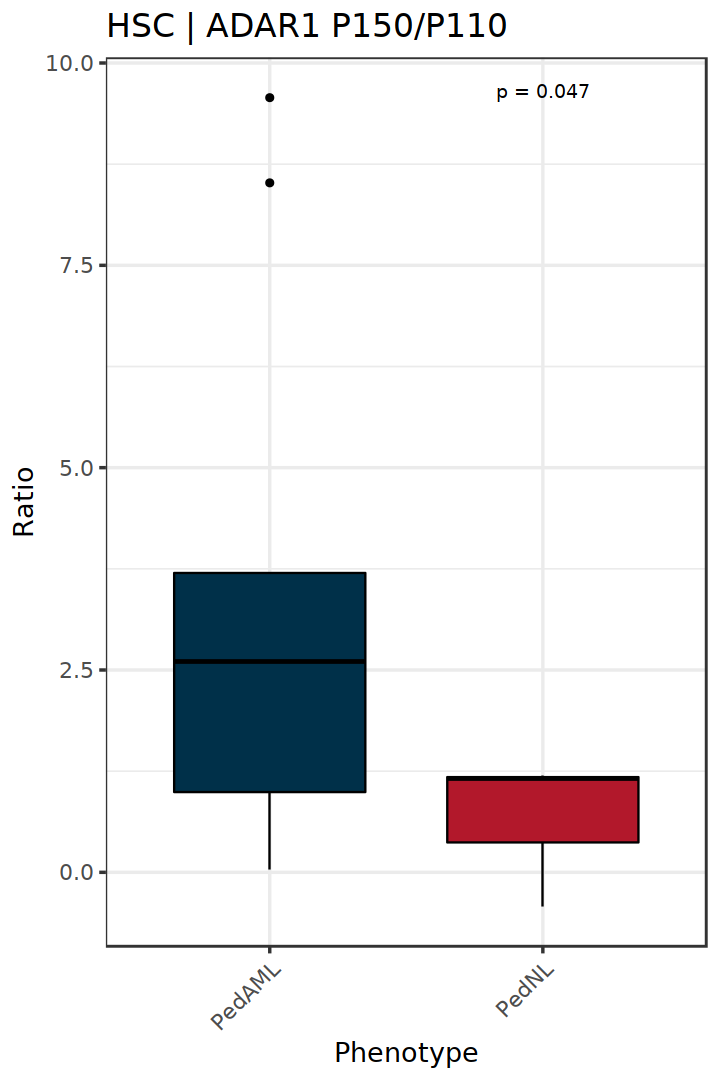

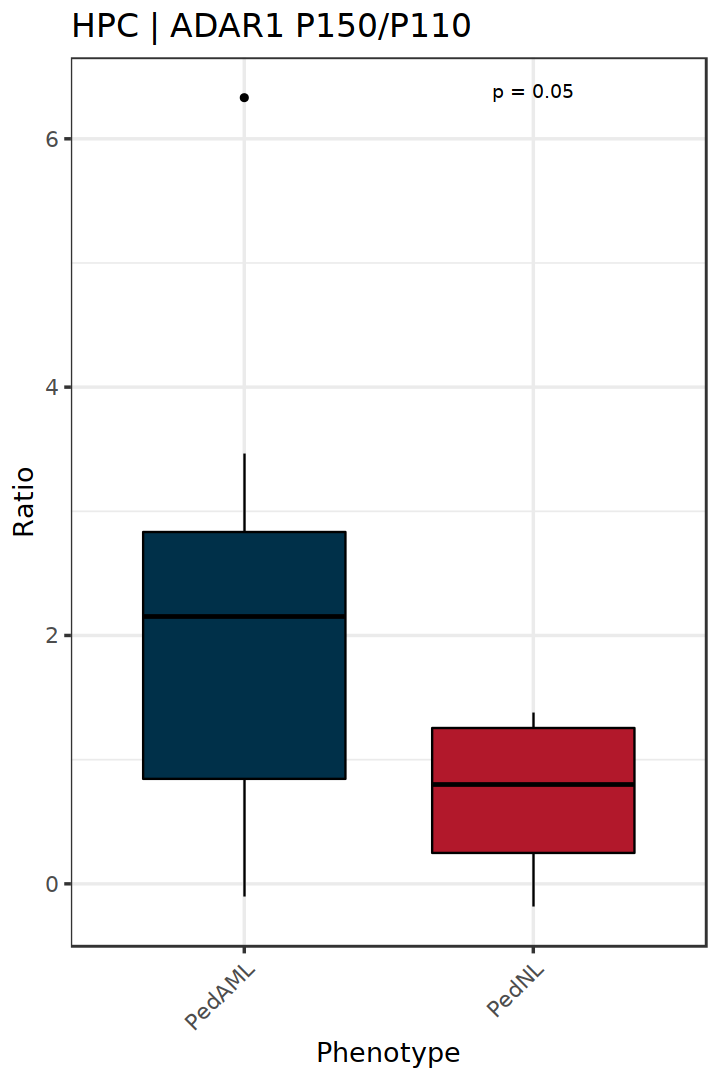

In [21]:
options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(ADAR.tx.lcpm.Stem.ratios.df, Phenotype != "AdultAML"), x="Phenotype", y="value", fill="Phenotype",
         palette = c("#003049", "#B2182B")) + 
    theme_bw(base_size=16) + ylab("Ratio") + labs(title="HSC | ADAR1 P150/P110") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none") + 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")

options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(ADAR.tx.lcpm.Prog.ratios.df, Phenotype != "AdultAML"), x="Phenotype", y="value", fill="Phenotype",
         palette = c("#003049", "#B2182B")) + 
    theme_bw(base_size=16) + ylab("Ratio") + labs(title="HPC | ADAR1 P150/P110") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none") + 
    
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")


## Fig S4g - Boxplot of PTPN6 - 003

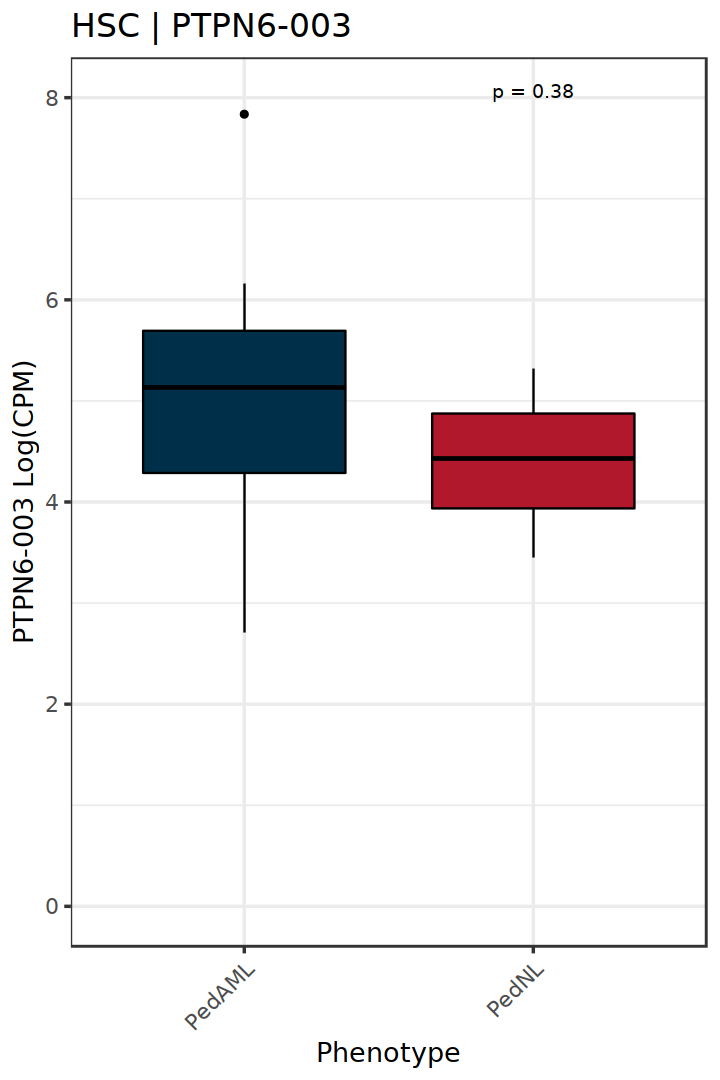

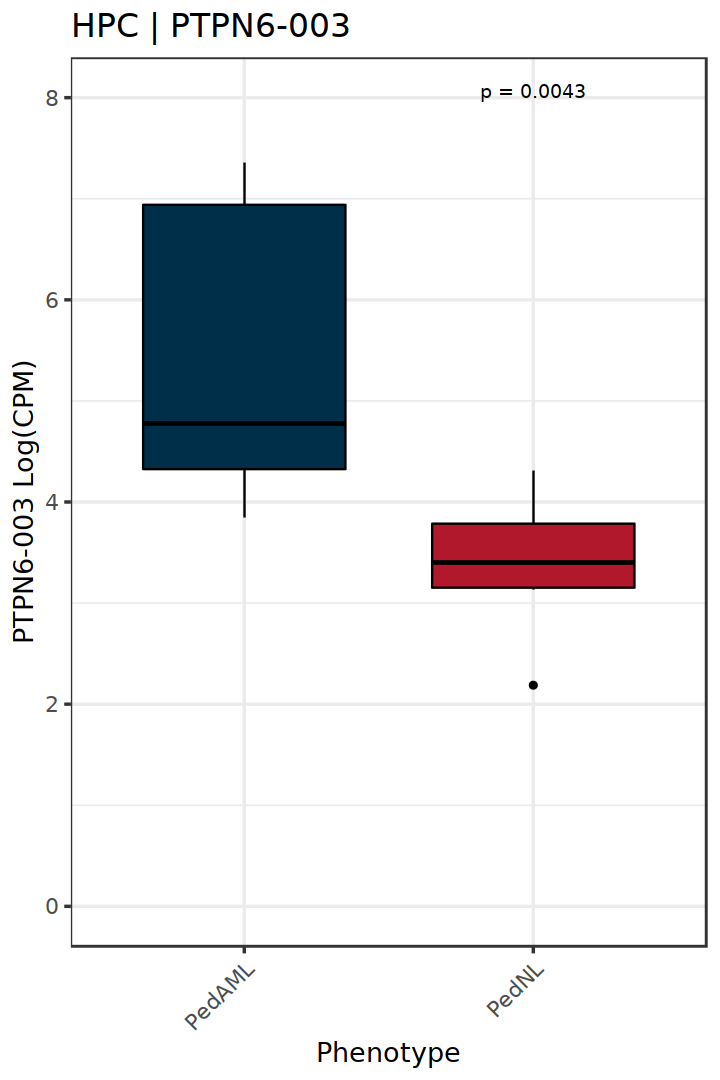

In [22]:
PTPN6.tx <- "ENST00000416215"
PTPN6.tx.exp.Prog.filt <- DGE_all.Prog.filt$counts[rownames(DGE_all.Prog.filt$counts) %in% PTPN6.tx,,drop=FALSE]
PTPN6.tx.exp.Stem.filt <- DGE_all.Stem.filt$counts[rownames(DGE_all.Stem.filt$counts) %in% PTPN6.tx,,drop=FALSE]
PTPN6.tx.lcpm.Prog.filt <- lcpm2.Prog.filt[rownames(lcpm2.Prog.filt) %in% PTPN6.tx,,drop=FALSE]
PTPN6.tx.lcpm.Stem.filt <- lcpm2.Stem.filt[rownames(lcpm2.Stem.filt) %in% PTPN6.tx,,drop=FALSE]

PTPN6.tx.lcpm.Prog.df <- as.data.frame(t(PTPN6.tx.lcpm.Prog.filt))
PTPN6.tx.lcpm.Prog.df$Phenotype <- factor(as.character(meta.Prog.filt[match(rownames(PTPN6.tx.lcpm.Prog.df), 
                                                                paste0("X", meta.Prog.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))

PTPN6.tx.lcpm.Stem.df <- as.data.frame(t(PTPN6.tx.lcpm.Stem.filt))
PTPN6.tx.lcpm.Stem.df$Phenotype <- factor(as.character(meta.Stem.filt[match(rownames(PTPN6.tx.lcpm.Stem.df), 
                                                                paste0("X", meta.Stem.filt$Sample)),"Phenotype"]), 
                                                           levels=c("PedAML", "AdultAML","PedNL"))
colnames(PTPN6.tx.lcpm.Stem.df)[1]<- colnames(PTPN6.tx.lcpm.Prog.df)[1] <- c("PTPN6.003")

options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(PTPN6.tx.lcpm.Stem.df, Phenotype != "AdultAML"), x="Phenotype", y="PTPN6.003", fill="Phenotype",
         palette = c("#003049","#B2182B")) + ylim(0,8) +
    theme_bw(base_size=16) + ylab("PTPN6-003 Log(CPM)") + labs(title="HSC | PTPN6-003") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none")+ 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")
options(repr.plot.width=6, repr.plot.height=9)
ggboxplot(subset(PTPN6.tx.lcpm.Prog.df, Phenotype != "AdultAML"), x="Phenotype", y="PTPN6.003", fill="Phenotype",
         palette = c("#003049","#B2182B")) + ylim(0,8) +
    theme_bw(base_size=16) + ylab("PTPN6-003 Log(CPM)") + labs(title="HPC | PTPN6-003") + 
    theme(axis.text.x = element_text(angle = 45, hjust=1), legend.position="none")+ 
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")


In [23]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/ubuntu/anaconda3/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1                          
 [2] gplots_3.1.1                           
 [3] reshape2_1.4.4                         
 [4] gdata_2.18.0                           
 [5] dplyr_1.0.7                            
 [6] plyr_1.8.6                             
 [7] statmod_1.4.36                         
 [8] Homo.sapiens_1.3.1          